In [1]:
# import python libraries
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re, pathlib, time, os, shutil, json
import matlab.engine

In [2]:
# define which models, vintage_dates, scenarios, forecast variables to investigate and root path
user_params = {
    'models': ['SW07'], # ['CMR14', 'DNGS15', 'DS04', 'FRBEDO08', 'FU20', 'GSW12', 'NKBGG', 'SW07', 'WW11'], # 'IN10', 'KR15_FF', 'KR15_HH', 'QPM08'
    'vintage_dates': ['20010214', ],  # '20010512', '20010815', '20011114', '20080807', '20081110', '20090210', '20090512', '20200211', '20200512', '20200812', '20201110', '20210209'
    'scenarios': ['s1', ], # 's2', 's3', 's4'
    'forecast_var': 'gdp_rgd_obs',
    'path_root': pathlib.Path('C://Users//dev//Documents//GitHub//MMB_forecast_application'),
}
assert user_params['path_root'].exists()
os.chdir(user_params['path_root'])

# define path for estimations
path_estim = user_params['path_root'] / 'estimations'
path_temp = user_params['path_root'] / 'temp'

# most models have "gdp_rgd_obs" and "gdpdef_obs"
# IN10 has "gdpl_rgd_obs" and "pi_dm_obs"
# QPM08 has "gdpl_rgd_obs" and "cpil_obs"

In [3]:
# results = dict()
# results_autotune = dict()

# for path in path_estim.glob('*'):

#     if 'DS04' in path.name and 'ew' not in path.name:
#         identifier = path.name.split('_')
#         if identifier[1] in user_params['vintage_dates'] and identifier[2] in user_params['scenarios']:

#             with open(path / 'DS04.json', 'r') as f:
#                 data = f.read()
#                 data = json.loads(data)

#             if len(identifier) == 3:
#                 results[path.name] = data['forecast']['gdp']
#             else:
#                 results_autotune[path.name.replace('_autotune_test', '')] = data['forecast']['gdp']

In [4]:
# rows = int(np.ceil(len(results) / 4))
# fig, axes = plt.subplots(rows, 4, figsize=(30, 8*rows))
# axes = axes.flatten()
# i = 0
# for key, values in results.items():
#     axes[i].plot(list(range(41)), values, label='not autotune')
#     axes[i].plot(list(range(41)), results_autotune[key], label='autotune')
#     axes[i].set_title(key)
#     axes[i].legend(loc='best')
#     i += 1

# plt.show()

In [5]:
# start Matlab engine
eng = matlab.engine.start_matlab('-desktop -nosplash')
time.sleep(10)

In [6]:
# place to store results
forecast_results = dict()

# loop through all the estimations
for path in path_estim.glob('*'):

    # only investigate estimations without suffix
    try:
        model, vintage_date, scenario = path.name.split('_')
    except:
        continue
        # print(f'Estimation {path.name} ignored as it has suffix')

    if model in user_params['models'] and vintage_date in user_params['vintage_dates'] and scenario in user_params['scenarios']:
        print(f'Program is running for {path.name} ...')

        # copy files to the temp folder and move to the temp folder
        shutil.copytree(path, path_temp)
        os.chdir(path_temp)

        # load workspace.mat
        workspace = sio.loadmat('workspace.mat')

        # get old forecast (if available)
        forecast_old = workspace['oo_'][0, 0][list(np.array(workspace['oo_'][0, 0].dtype.names)).index('MeanForecast')][0][0][0][0][0]
        try:
            forecast_old_var = list(np.squeeze(forecast_old[list(forecast_old.dtype.names).index(user_params['forecast_var'])]))
        except:
            forecast_old_var = list()

        # create strings for posterior means and stds
        posterior_means = workspace['oo_'][0, 0][list(np.array(workspace['oo_'][0, 0].dtype.names)).index('posterior_mean')][0][0]
        parameters, shock_std = posterior_means

        str_posterior_means = '\n'
        for name, value in zip(parameters.dtype.names, parameters[0][0]):
            str_posterior_means += f'{name} = {value[0][0]};\n'
        # print(str_posterior_means)
        str_posterior_std = '\nshocks;\n'
        for name, value in zip(shock_std.dtype.names, shock_std[0][0]):
            str_posterior_std += f'var {name}; stderr {value[0][0]};\n'
        str_posterior_std += 'end;\n'
        # print(str_posterior_std)

        # load modfile
        modfile_name = model+'.mod'
        with open(modfile_name, 'r') as f:
            mod_file = f.read()

        if 'mh_tune_jscale' in mod_file:
            autotune = '_autotune'
        else:
            autotune = ''

        # initialization of the insert place
        insert_place1, insert_place2, start_place1, start_place2, end_place1, end_place2 = '0'*6

        # insert posterior means of parameters before "model;" or "model(linear);"
        model_start = re.search('\n(model|model\(linear\))( ){0,1};( ){0,}\n', mod_file)
        if model_start == None:
            print('cannot find string "model;" or "model(linear);"')
        else:
            insert_place1 = model_start.start(0)
            mod_file = mod_file[:insert_place1] + str_posterior_means + mod_file[insert_place1:]

            # rewrite "shocks" block to insert posterior means of std of shocks
            shocks_start = re.search('\nshocks( ){0,1};( ){0,}\n', mod_file)
            if shocks_start == None:
                print('cannot find string "shocks;"')
            else:
                start_place1 = shocks_start.start(0)
                shocks_end = re.search('\nend( ){0,1};( ){0,}\n', mod_file[start_place1:])
                if shocks_end == None:
                    print('cannot find string "end;" immediately after "shocks;"')
                else:
                    end_place1 = shocks_end.end(0)
                    mod_file = mod_file[:start_place1] + str_posterior_std + mod_file[start_place1+end_place1:]

                    # remove "estimated_params" block
                    estimp_start = re.search('\nestimated_params( ){0,1};( ){0,}\n', mod_file)
                    if estimp_start == None:
                        print('cannot find string "estimated_params;"')
                    else:
                        start_place2 = estimp_start.start(0)
                        estimp_end = re.search('\nend( ){0,1};( ){0,}\n', mod_file[start_place2:])
                        if estimp_end == None:
                            print('cannot find string "end;" immediately after "estimated_params;"')
                        else:
                            end_place2 = estimp_end.end(0)
                            mod_file = mod_file[:start_place2] + mod_file[start_place2+end_place2:]

                            # change the estimation command
                            estim = re.search('\nestimation(.*)(datafile=data_\d{8}, xls_sheet=s\d{1}, xls_range=.{1,}, presample=4, )(.*);', mod_file)
                            if estim == None:
                                print('cannot find string satisfying the regular expression for the "estimation" command')
                            else:
                                insert_place2 = estim.start(0)
                                new_estim = '\nestimation(nodisplay, smoother, order=1, prefilter=0, ' + estim.group(2) + 'mode_compute=0, forecast=40) ' + user_params['forecast_var'] + ';'
                                mod_file = mod_file[:insert_place2] + new_estim


        # print(mod_file)

        # write to modfile
        with open(modfile_name, 'w') as f:
            f.write(mod_file)

        # use Dynare to calculate forecasts
        eng.cd(str(path_temp), nargout=0)
        eng.dynare(modfile_name, nargout=0)
        forecast_new_var = list(np.squeeze(np.array(eng.workspace['oo_']['forecast']['Mean'][user_params['forecast_var']])))
        eng.eval('clear all; close all; diary off;', nargout=0)
        eng.cd(str(user_params['path_root']), nargout=0)
        
        # delete temp folder
        # os.chdir(user_params['path_root'])
        # shutil.rmtree(path_temp, ignore_errors=True)



        forecast_results[path.name] = (forecast_old_var, forecast_new_var)

# eng.exit()
print('Done.')

Program is running for SW07_20010214_s1 ...
Done.


In [30]:
# path_archive = user_params['path_root'] / 'archived' / 'estimations'

# # loop through all the estimations
# for path in path_archive.glob('*'):

#     # only investigate estimations without suffix
#     try:
#         model, vintage_date, scenario = path.name.split('_')
#     except:
#         continue
#         # print(f'Estimation {path.name} ignored as it has suffix')

#     if model in user_params['models'] and vintage_date in user_params['vintage_dates'] and scenario in user_params['scenarios']:
#         print(f'Program is running for {path.name} ...')

#         # copy files to the temp folder and move to the temp folder
#         shutil.copytree(path, path_temp)
#         os.chdir(path_temp)

#         # load workspace.mat
#         workspace = sio.loadmat('workspace.mat')

#         # get old forecast (if available)
#         forecast_old = workspace['oo_'][0, 0][list(np.array(workspace['oo_'][0, 0].dtype.names)).index('MeanForecast')][0][0][0][0][0]
#         try:
#             forecast_old_var = list(np.squeeze(forecast_old[list(forecast_old.dtype.names).index(user_params['forecast_var'])]))
#         except:
#             forecast_old_var = list()

#         # load modfile
#         modfile_name = model+'.mod'
#         with open(modfile_name, 'r') as f:
#             mod_file = f.read()

#         if 'mh_tune_jscale' in mod_file:
#             autotune = '_autotune'
#         else:
#             autotune = ''

#         # delete temp folder
#         os.chdir(user_params['path_root'])
#         shutil.rmtree(path_temp, ignore_errors=True)

#         forecast_results[path.name] = (forecast_results[path.name][0], forecast_results[path.name][1], forecast_old_var)

# print('Done.')

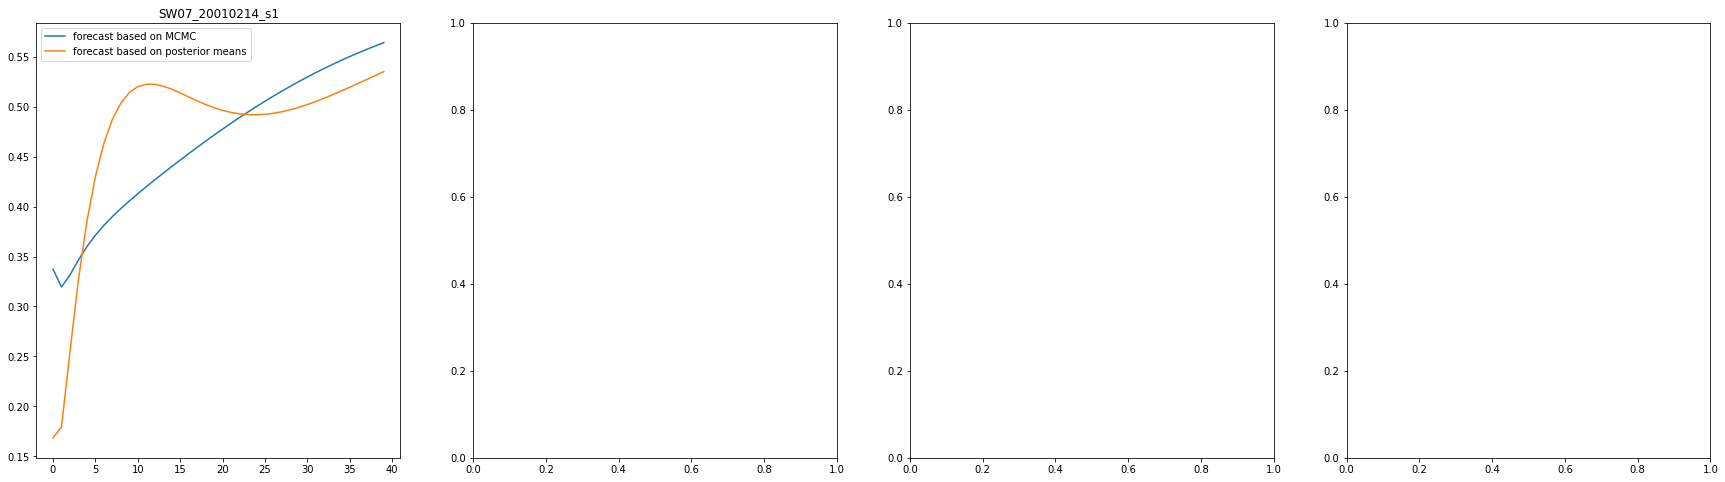

In [7]:
rows = int(np.ceil(len(forecast_results) / 4))
fig, axes = plt.subplots(rows, 4, figsize=(30, 8*rows))
axes = axes.flatten()
i = 0
for key, values in forecast_results.items():
    axes[i].plot(list(range(40)), forecast_results[key][0], label='forecast based on MCMC')
    axes[i].plot(list(range(40)), forecast_results[key][1], label='forecast based on posterior means')
    axes[i].set_title(key)
    axes[i].legend(loc='best')
    i += 1

plt.show()

In [31]:
# rows = int(np.ceil(len(forecast_results) / 4))
# fig, axes = plt.subplots(rows, 4, figsize=(30, 8*rows))
# for i in range(len(forecast_results)):
#     results = forecast_results[list(forecast_results.keys())[i]]
#     axes[i].plot(list(range(40)), results[0])
#     axes[i].plot(list(range(40)), results[1])
#     axes[i].set_title(list(forecast_results.keys())[i])

# plt.show()

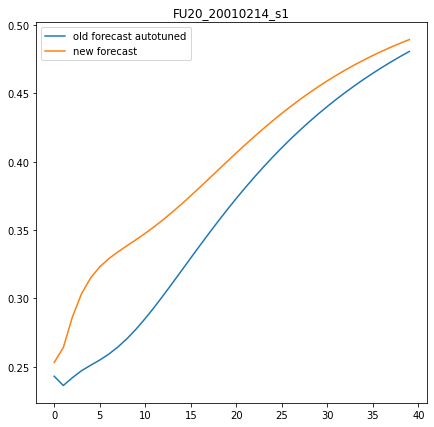

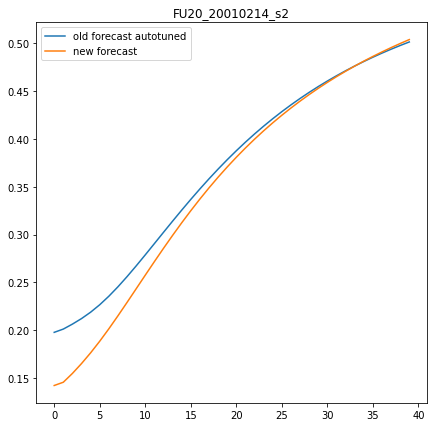

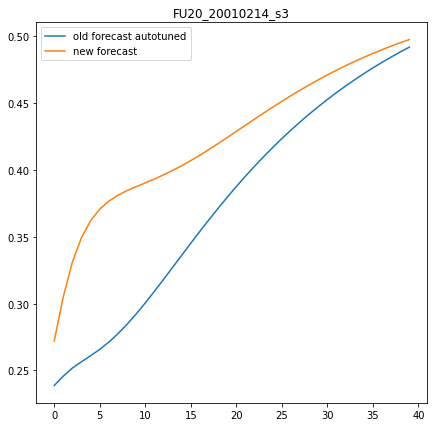

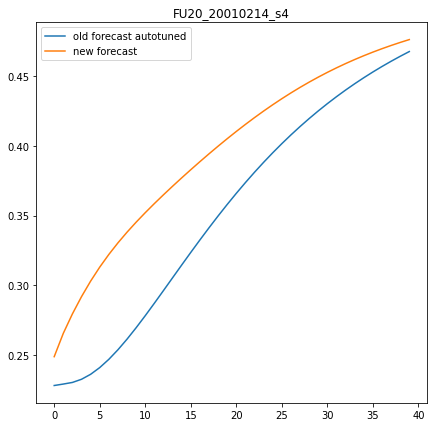

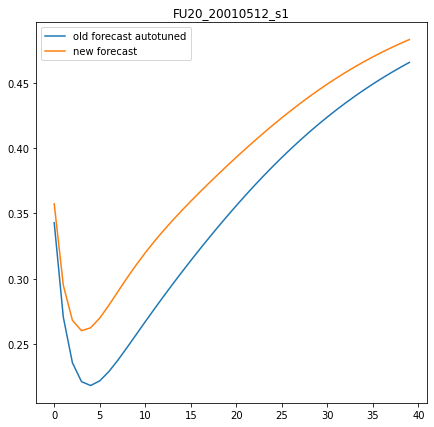

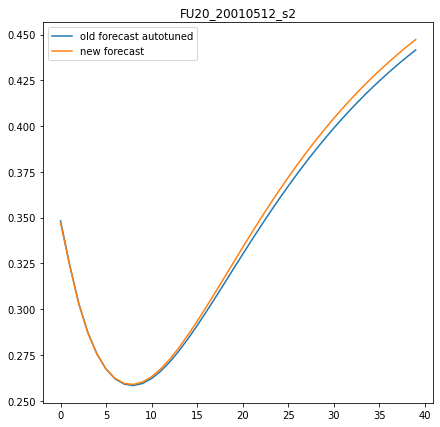

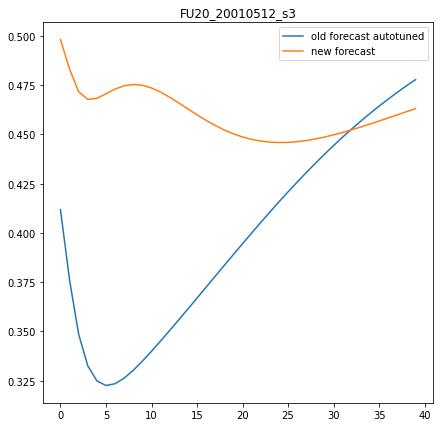

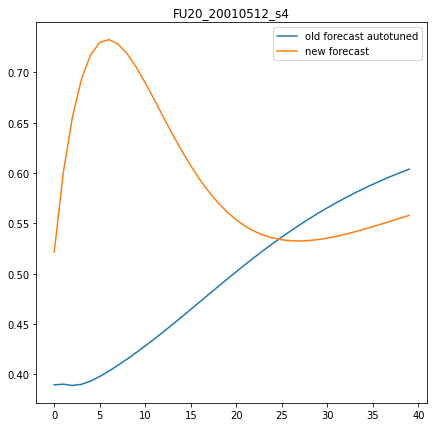

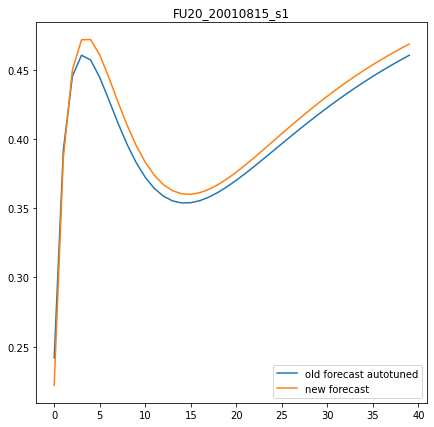

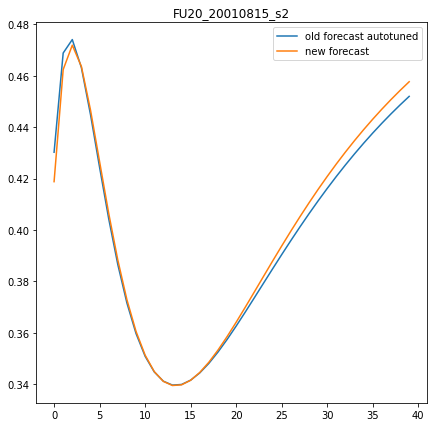

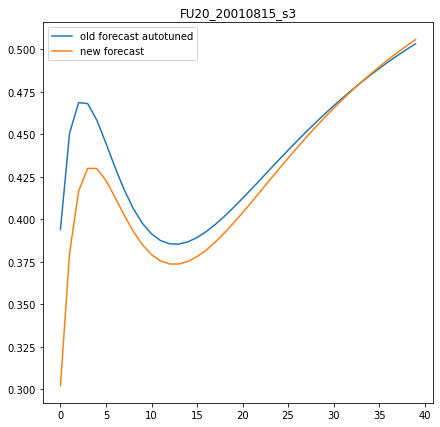

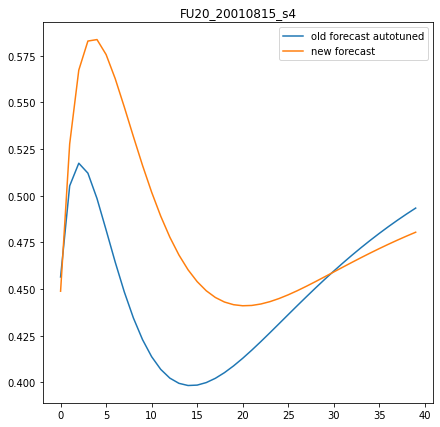

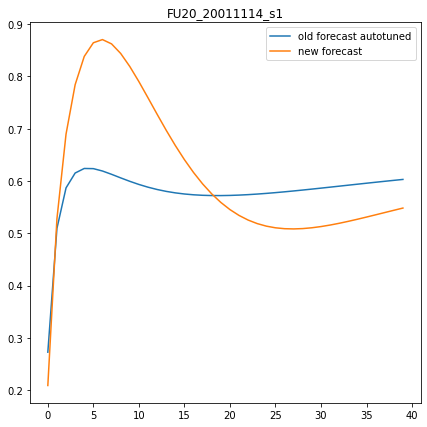

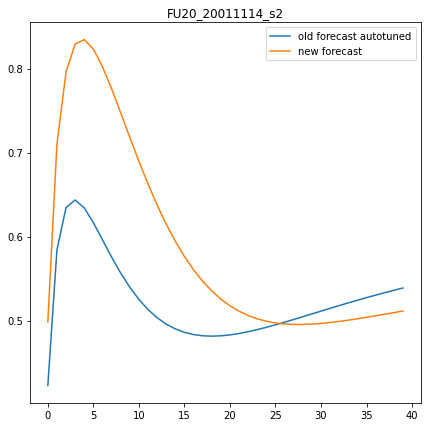

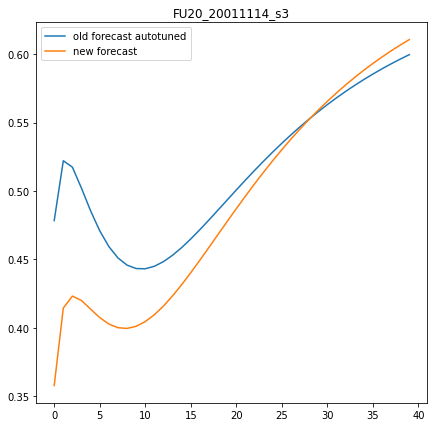

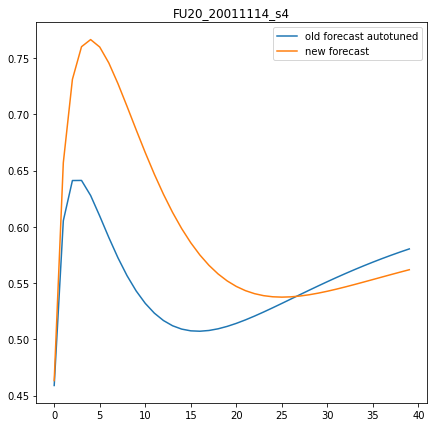

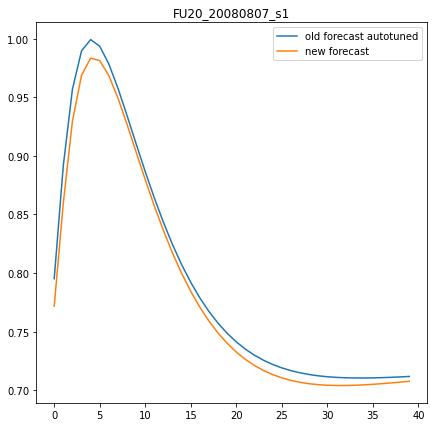

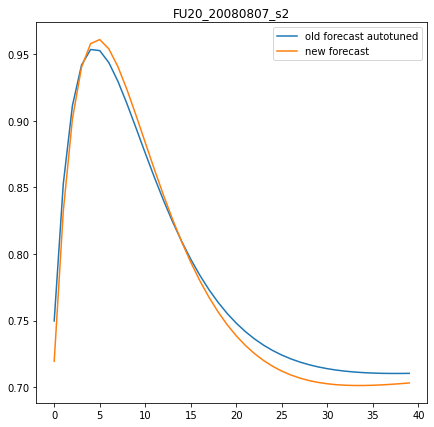

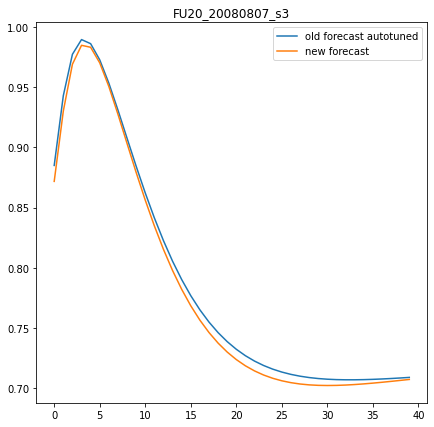

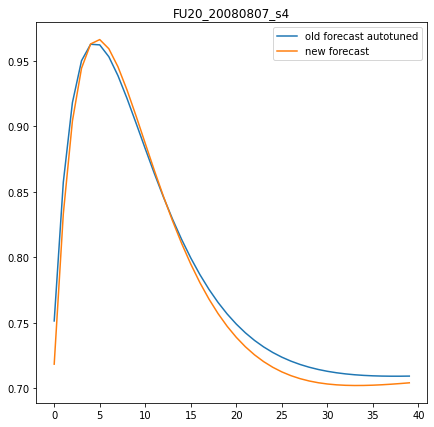

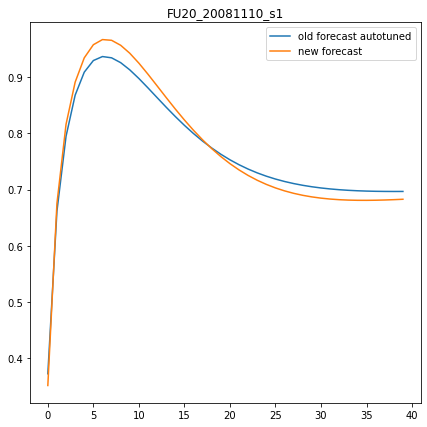

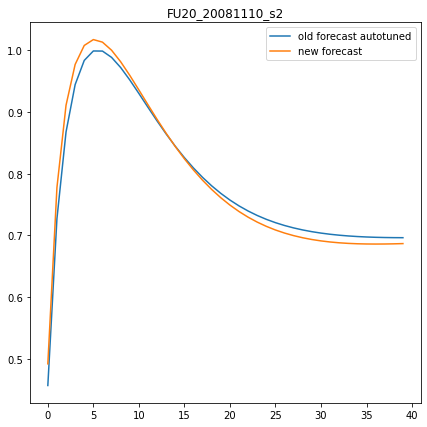

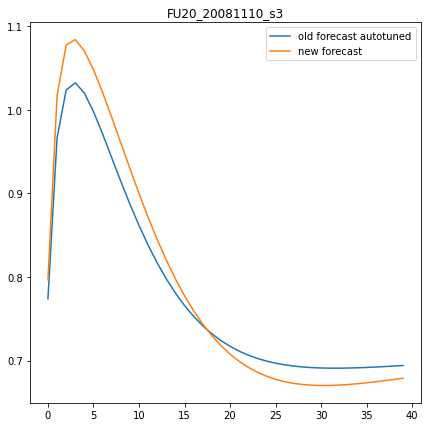

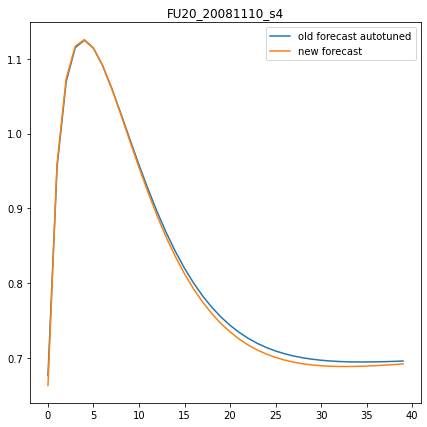

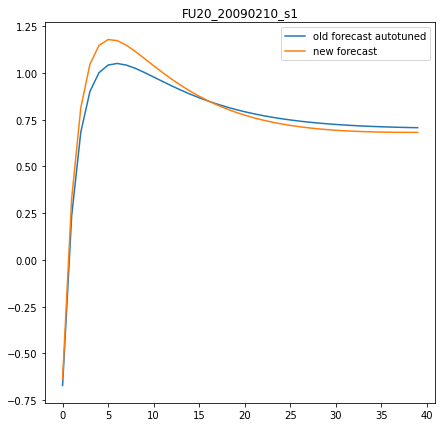

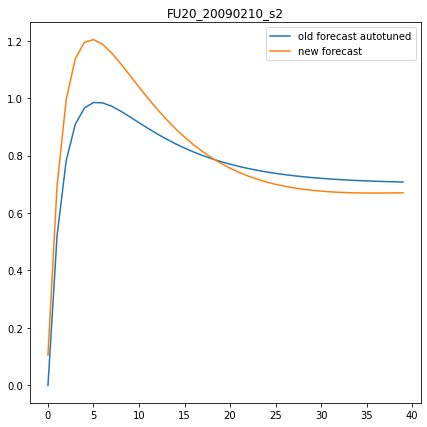

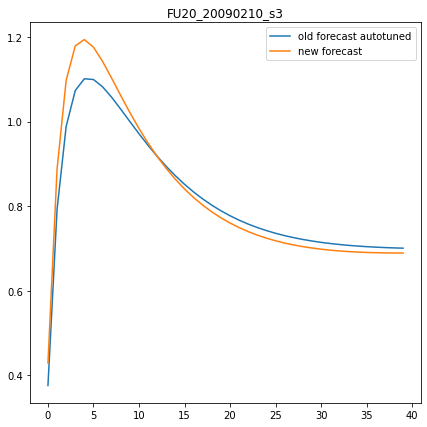

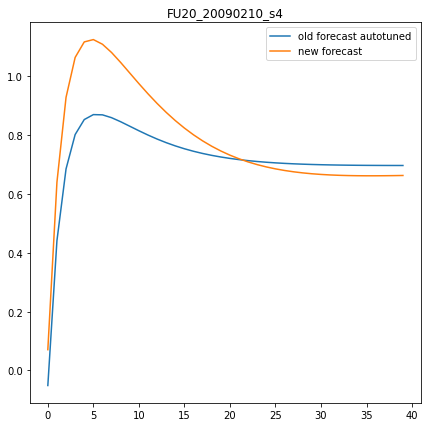

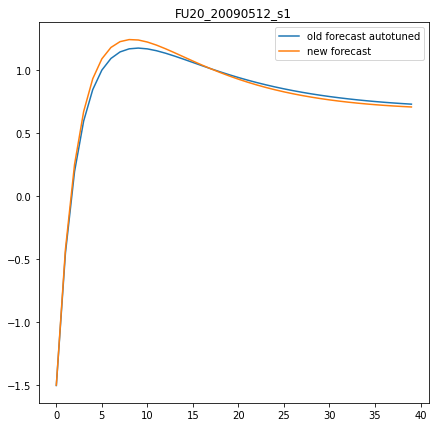

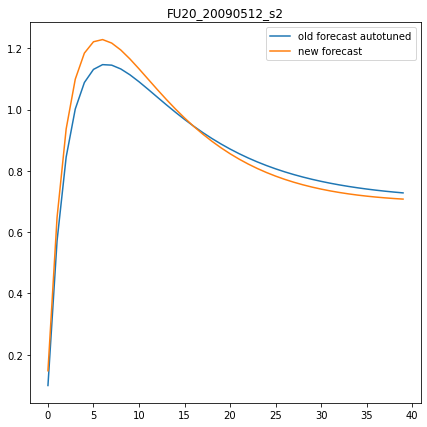

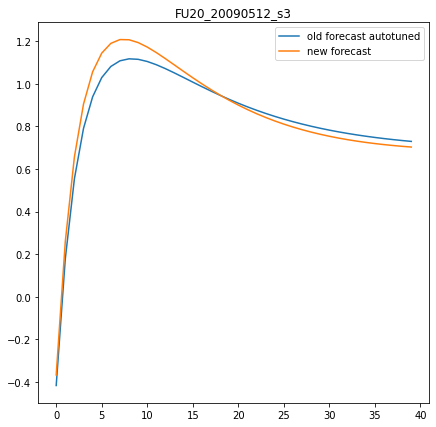

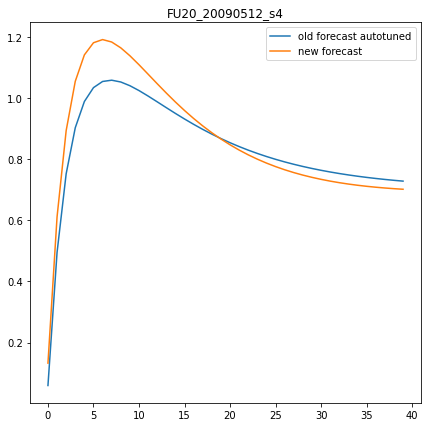

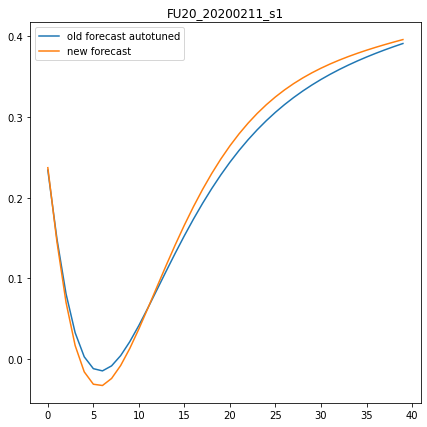

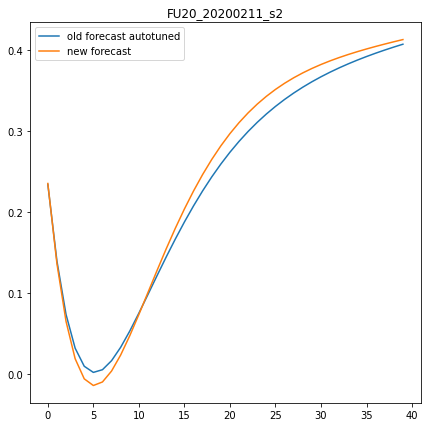

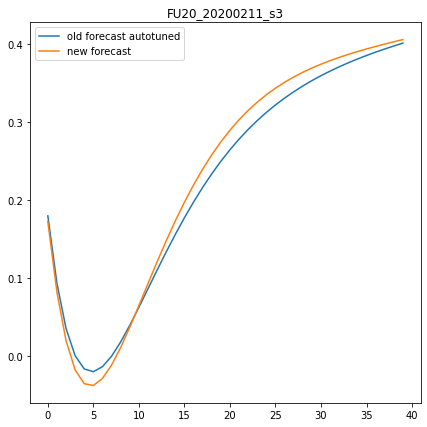

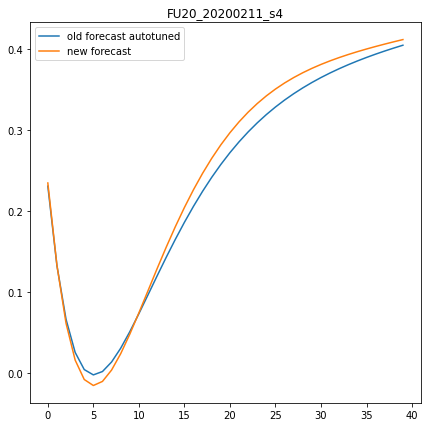

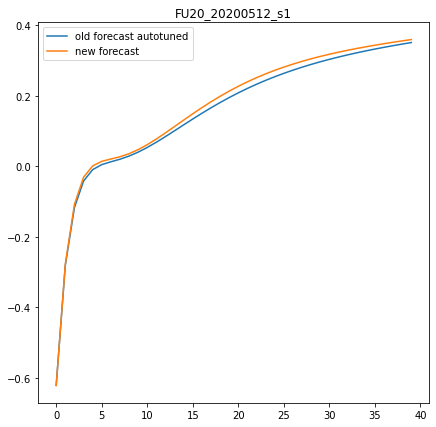

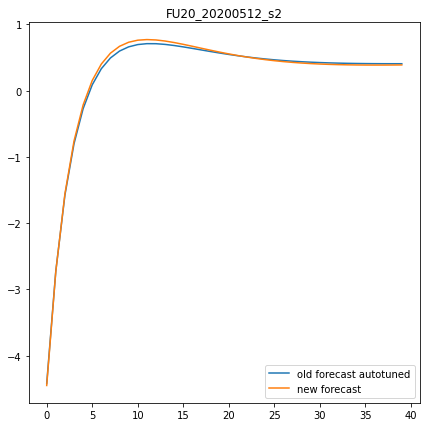

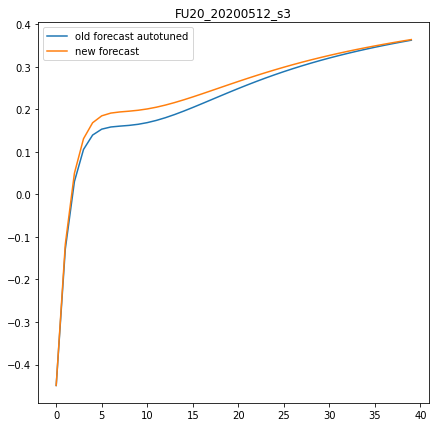

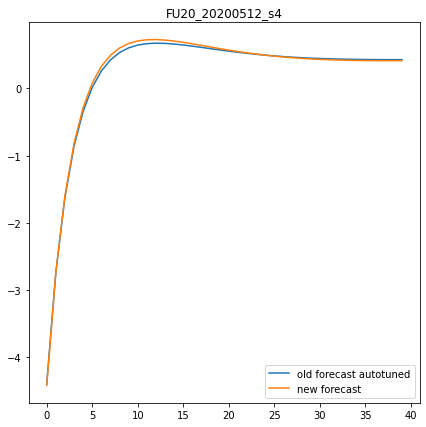

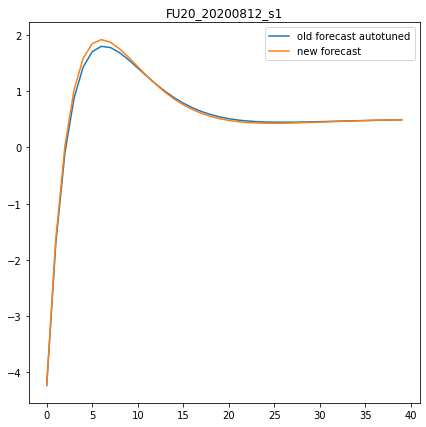

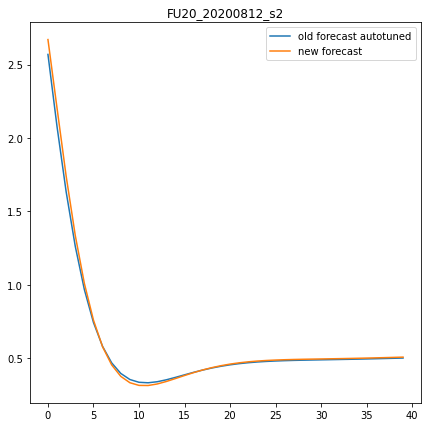

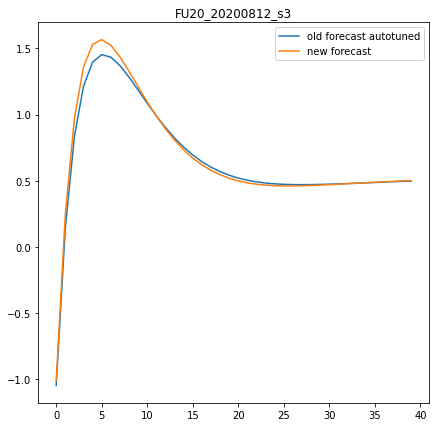

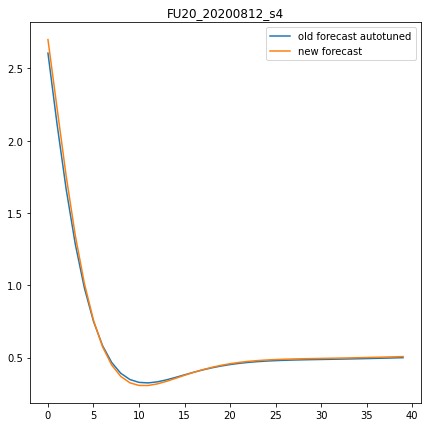

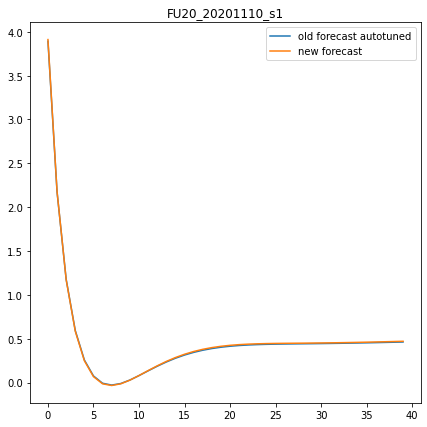

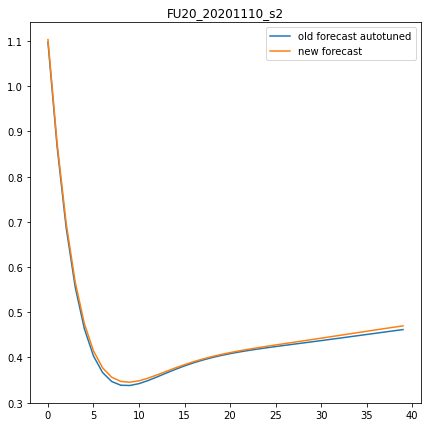

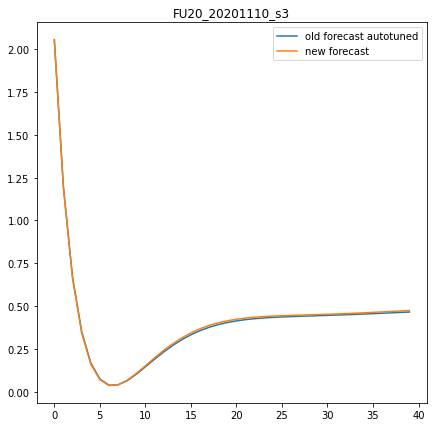

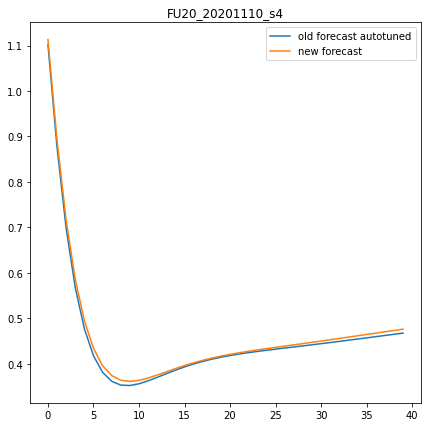

In [32]:
for i in range(len(forecast_results)):
    fig, axes = plt.subplots(1, 1, figsize=(7, 7))
    results = forecast_results[list(forecast_results.keys())[i]]
    axes.plot(list(range(40)), results[0], label='old forecast autotuned')
    axes.plot(list(range(40)), results[1], label='new forecast')
    # axes.plot(list(range(40)), results[2], label='old forecast not autotuned')
    axes.set_title(list(forecast_results.keys())[i])
    axes.legend(loc='best')
    plt.show()